In [1]:
# generate_uber_dataset.py
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

def generate_uber_dataset(num_records=50000):
    np.random.seed(42)

    # Base parameters for normal fares
    base_fare = 8.0
    cost_per_mile = 2.5
    cost_per_minute = 0.3

    # Generate dates (last 6 months)
    end_date = datetime.now()
    start_date = end_date - timedelta(days=180)

    data = []

    for i in range(num_records):
        # Random trip characteristics
        distance = np.random.lognormal(2.5, 0.8)  # miles
        duration = np.random.lognormal(3.0, 0.6)  # minutes
        surge_multiplier = 1.0

        # Time-based features
        trip_date = start_date + timedelta(
            days=random.randint(0, 180),
            hours=random.randint(0, 23),
            minutes=random.randint(0, 59)
        )

        hour = trip_date.hour
        day_of_week = trip_date.weekday()

        # Location features
        pickup_lat = np.random.uniform(40.6, 40.9)
        pickup_lng = np.random.uniform(-74.1, -73.7)
        dropoff_lat = np.random.uniform(40.6, 40.9)
        dropoff_lng = np.random.uniform(-74.1, -73.7)

        # Calculate base fare
        fare = base_fare + (distance * cost_per_mile) + (duration * cost_per_minute)

        # Add surge pricing during rush hours
        if (7 <= hour <= 10) or (16 <= hour <= 19):
            surge_multiplier = np.random.uniform(1.2, 2.0)
            fare *= surge_multiplier

        # Introduce anomalies (5% of records)
        is_anomaly = 0
        anomaly_type = None

        if np.random.random() < 0.05:  # 5% anomalies
            is_anomaly = 1
            anomaly_type = np.random.choice(['overcharge', 'undercharge', 'distance_outlier', 'duration_outlier'])

            if anomaly_type == 'overcharge':
                fare *= np.random.uniform(3, 10)  # 3x to 10x overcharge
            elif anomaly_type == 'undercharge':
                fare *= np.random.uniform(0.1, 0.3)  # 70-90% discount
            elif anomaly_type == 'distance_outlier':
                distance *= np.random.uniform(5, 20)  # Extremely long distance
                fare = base_fare + (distance * cost_per_mile) + (duration * cost_per_minute)
            elif anomaly_type == 'duration_outlier':
                duration *= np.random.uniform(5, 15)  # Extremely long duration
                fare = base_fare + (distance * cost_per_mile) + (duration * cost_per_minute)

        # Add some random noise to normal fares
        if not is_anomaly:
            fare *= np.random.uniform(0.9, 1.1)

        # Ensure fare is reasonable
        fare = max(5.0, fare)

        record = {
            'trip_id': f'trip_{i:06d}',
            'datetime': trip_date,
            'hour': hour,
            'day_of_week': day_of_week,
            'distance_miles': round(distance, 2),
            'duration_minutes': round(duration, 1),
            'pickup_lat': round(pickup_lat, 6),
            'pickup_lng': round(pickup_lng, 6),
            'dropoff_lat': round(dropoff_lat, 6),
            'dropoff_lng': round(dropoff_lng, 6),
            'surge_multiplier': round(surge_multiplier, 2),
            'fare_amount': round(fare, 2),
            'is_anomaly': is_anomaly,
            'anomaly_type': anomaly_type if is_anomaly else 'normal'
        }

        data.append(record)

    return pd.DataFrame(data)

# Generate and save the dataset
print("Generating Uber fare anomaly dataset...")
df = generate_uber_dataset(50000)
df.to_csv('uber_fare_anomalies.csv', index=False)
print(f"Dataset generated with {len(df)} records")
print(f"Anomalies: {df['is_anomaly'].sum()} ({df['is_anomaly'].mean()*100:.2f}%)")

Generating Uber fare anomaly dataset...
Dataset generated with 50000 records
Anomalies: 2505 (5.01%)


In [2]:
# uber_fare_anomaly_analysis.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
print("Loading dataset...")
df = pd.read_csv('uber_fare_anomalies.csv')
df['datetime'] = pd.to_datetime(df['datetime'])

print(f"Dataset shape: {df.shape}")
print(f"Anomaly rate: {df['is_anomaly'].mean():.3f}")
print("\nFirst few records:")
display(df.head())

Loading dataset...
Dataset shape: (50000, 14)
Anomaly rate: 0.050

First few records:


,trip_id,datetime,hour,day_of_week,distance_miles,duration_minutes,pickup_lat,pickup_lng,dropoff_lat,dropoff_lng,surge_multiplier,fare_amount,is_anomaly,anomaly_type
0,trip_000000,2025-05-28 23:13:25.875154,23,2,18.13,18.5,40.819598,-73.860537,40.646806,-74.037602,1.00,63.17,0,normal
1,trip_000001,2025-07-26 09:01:25.875154,9,5,43.09,31.8,40.606175,-73.712036,40.849733,-74.015064,1.35,161.96,0,normal
2,trip_000002,2025-08-26 23:13:25.875154,23,1,1.51,35.5,40.687369,-73.855259,40.641848,-73.983142,1.00,22.23,0,normal
3,trip_000003,2025-09-06 03:14:25.875154,3,5,7.36,28.7,40.754270,-73.863034,40.613935,-73.856982,1.00,31.98,0,normal
4,trip_000004,2025-09-20 17:53:25.875154,17,5,7.54,35.5,40.629302,-73.826307,40.732046,-74.051185,1.60,10.66,1,undercharge


In [3]:
# Basic dataset info
print("Dataset Information:")
print("="*50)
print(df.info())
print("\nDescriptive Statistics:")
print("="*50)
print(df.describe())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   trip_id           50000 non-null  object        
 1   datetime          50000 non-null  datetime64[ns]
 2   hour              50000 non-null  int64         
 3   day_of_week       50000 non-null  int64         
 4   distance_miles    50000 non-null  float64       
 5   duration_minutes  50000 non-null  float64       
 6   pickup_lat        50000 non-null  float64       
 7   pickup_lng        50000 non-null  float64       
 8   dropoff_lat       50000 non-null  float64       
 9   dropoff_lng       50000 non-null  float64       
 10  surge_multiplier  50000 non-null  float64       
 11  fare_amount       50000 non-null  float64       
 12  is_anomaly        50000 non-null  int64         
 13  anomaly_type      50000 non-null  object        
dtypes

Anomaly Distribution:
anomaly_type
normal              47495
undercharge           657
distance_outlier      648
duration_outlier      605
overcharge            595
Name: count, dtype: int64


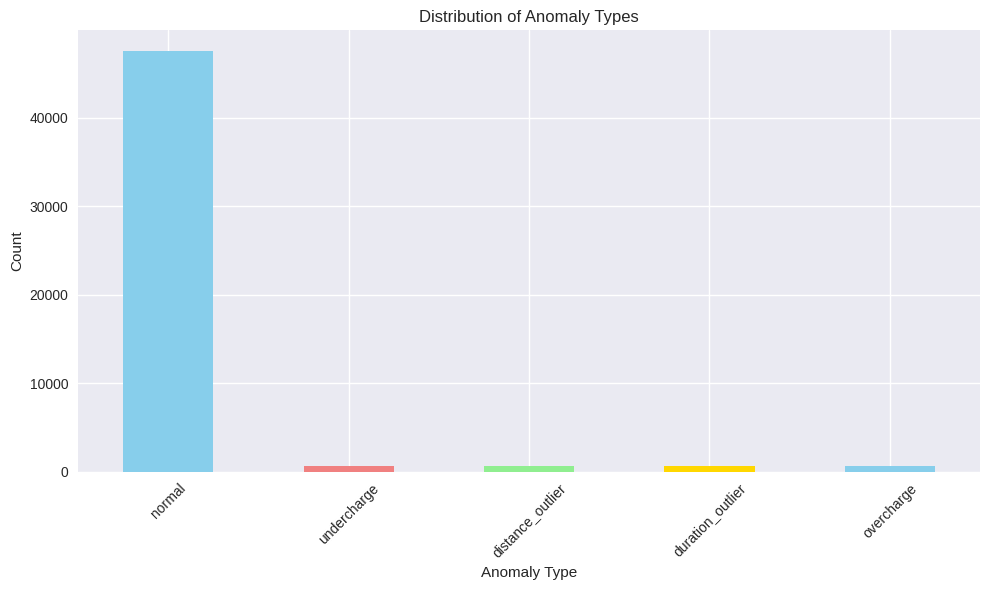

In [4]:
# Anomaly distribution
print("Anomaly Distribution:")
print("="*50)
anomaly_counts = df['anomaly_type'].value_counts()
print(anomaly_counts)

plt.figure(figsize=(10, 6))
anomaly_counts.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
plt.title('Distribution of Anomaly Types')
plt.xlabel('Anomaly Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

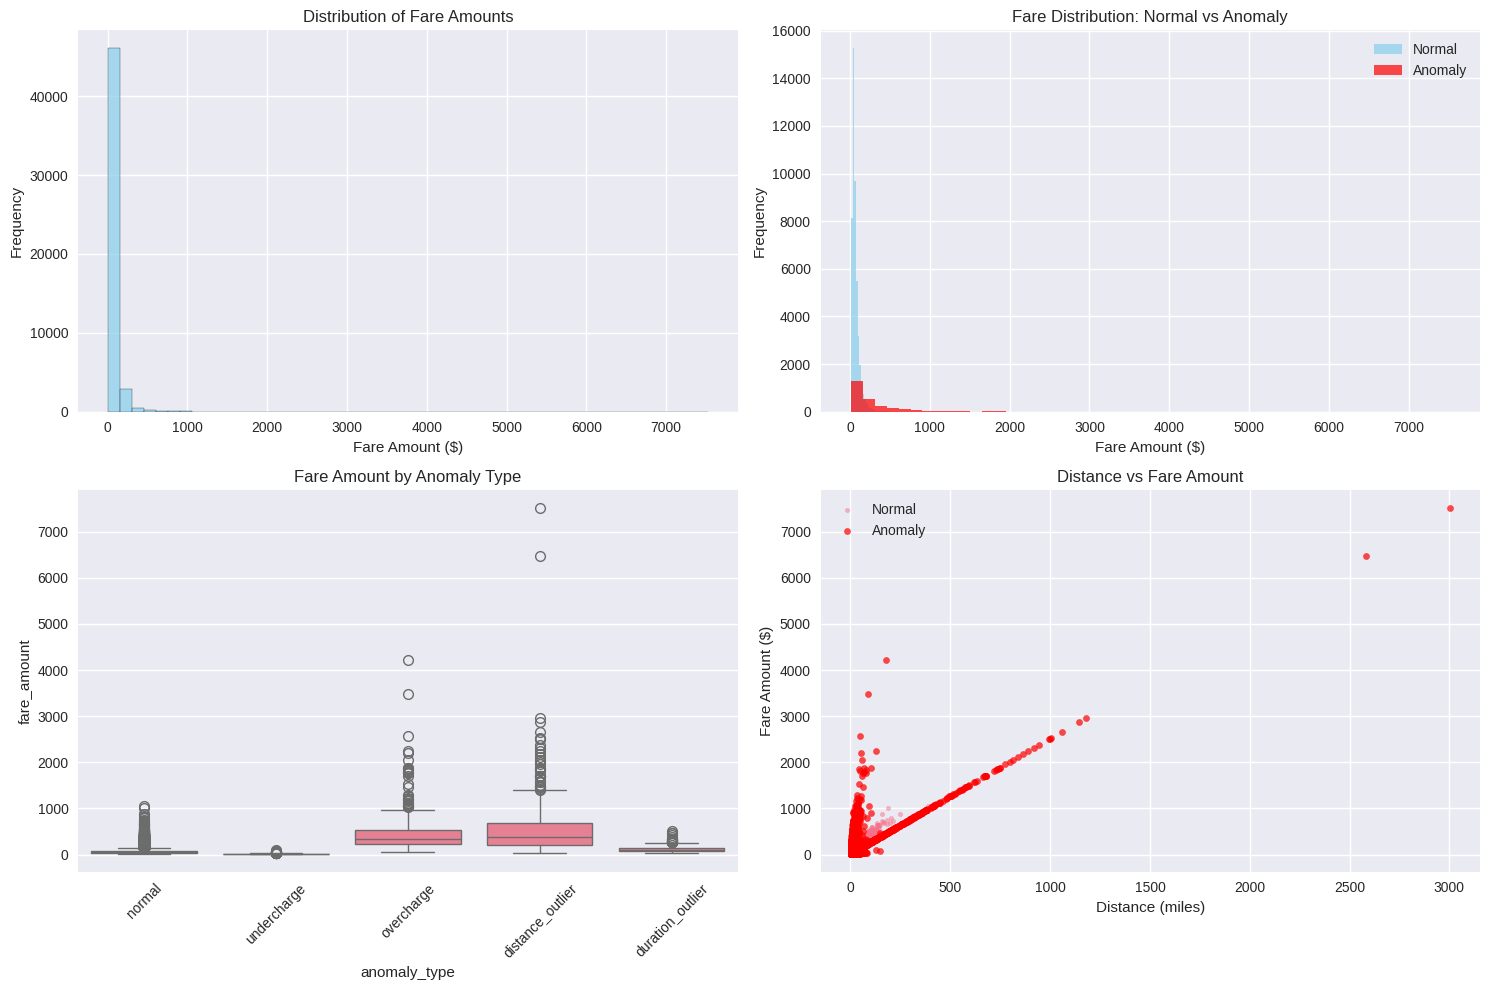

In [5]:
# Fare distribution analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(df['fare_amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
normal_fares = df[df['is_anomaly'] == 0]['fare_amount']
anomaly_fares = df[df['is_anomaly'] == 1]['fare_amount']
plt.hist(normal_fares, bins=50, alpha=0.7, label='Normal', color='skyblue')
plt.hist(anomaly_fares, bins=50, alpha=0.7, label='Anomaly', color='red')
plt.title('Fare Distribution: Normal vs Anomaly')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(2, 2, 3)
# Box plot by anomaly type
sns.boxplot(x='anomaly_type', y='fare_amount', data=df)
plt.title('Fare Amount by Anomaly Type')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
# Distance vs Fare colored by anomaly
plt.scatter(df[df['is_anomaly']==0]['distance_miles'],
           df[df['is_anomaly']==0]['fare_amount'],
           alpha=0.5, label='Normal', s=10)
plt.scatter(df[df['is_anomaly']==1]['distance_miles'],
           df[df['is_anomaly']==1]['fare_amount'],
           alpha=0.7, label='Anomaly', s=20, color='red')
plt.xlabel('Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.title('Distance vs Fare Amount')
plt.legend()

plt.tight_layout()
plt.show()

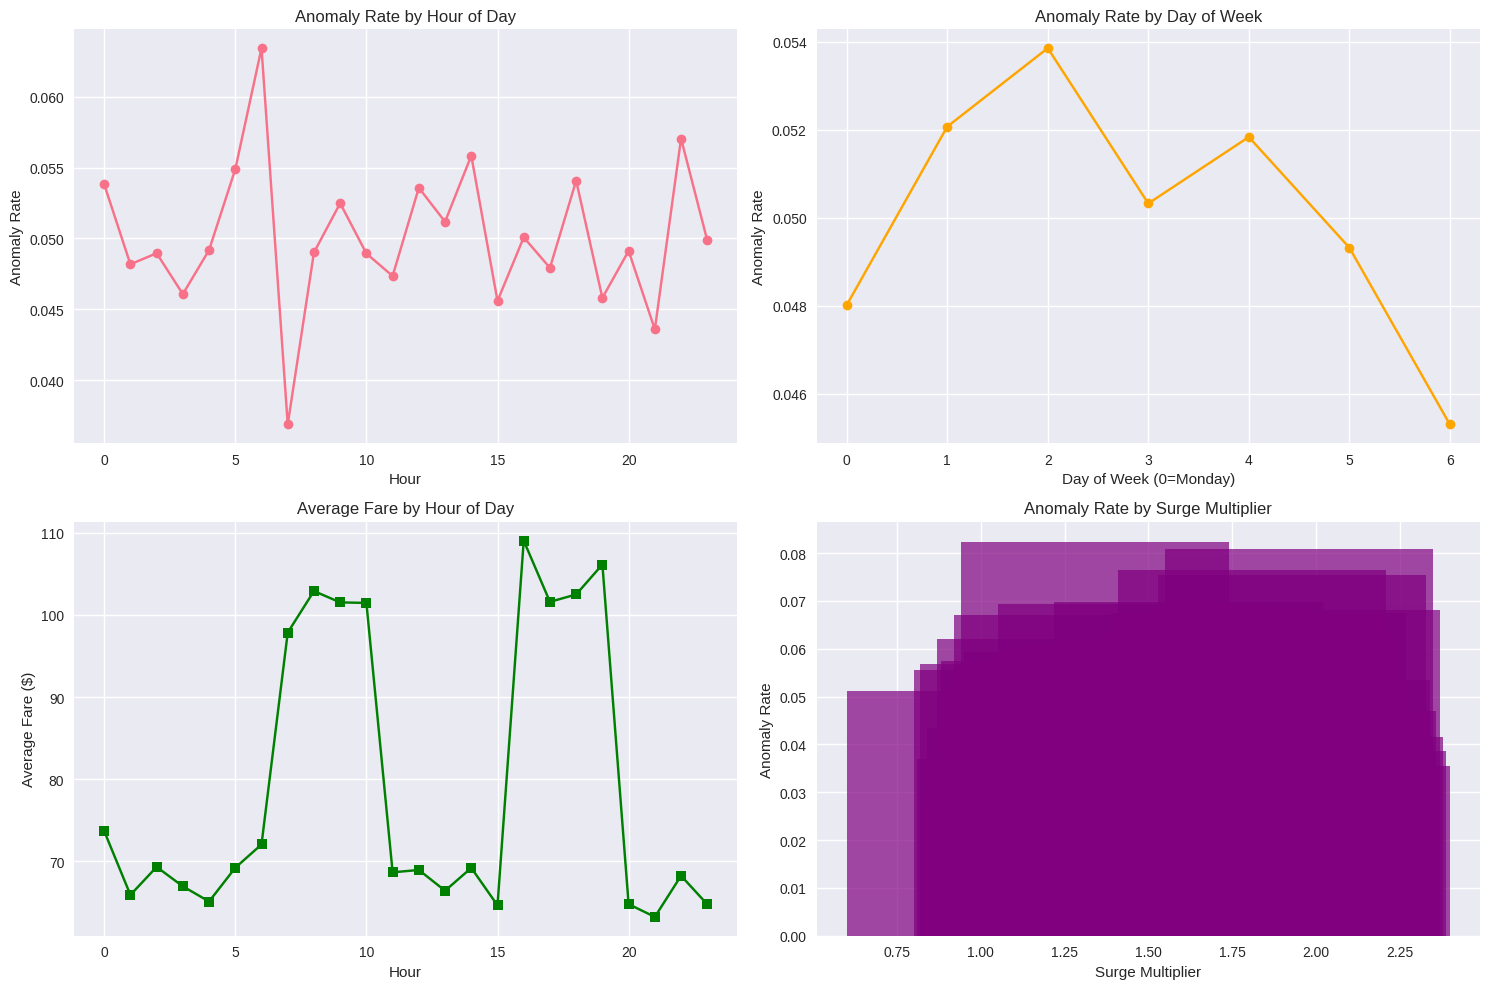

In [6]:
# Temporal analysis
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
hourly_anomalies = df.groupby('hour')['is_anomaly'].mean()
plt.plot(hourly_anomalies.index, hourly_anomalies.values, marker='o')
plt.title('Anomaly Rate by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Anomaly Rate')
plt.grid(True)

plt.subplot(2, 2, 2)
daily_anomalies = df.groupby('day_of_week')['is_anomaly'].mean()
plt.plot(daily_anomalies.index, daily_anomalies.values, marker='o', color='orange')
plt.title('Anomaly Rate by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Anomaly Rate')
plt.grid(True)

plt.subplot(2, 2, 3)
# Average fare by hour
hourly_fare = df.groupby('hour')['fare_amount'].mean()
plt.plot(hourly_fare.index, hourly_fare.values, marker='s', color='green')
plt.title('Average Fare by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Fare ($)')
plt.grid(True)

plt.subplot(2, 2, 4)
# Surge multiplier analysis
surge_analysis = df.groupby('surge_multiplier')['is_anomaly'].mean()
plt.bar(surge_analysis.index, surge_analysis.values, color='purple', alpha=0.7)
plt.title('Anomaly Rate by Surge Multiplier')
plt.xlabel('Surge Multiplier')
plt.ylabel('Anomaly Rate')

plt.tight_layout()
plt.show()

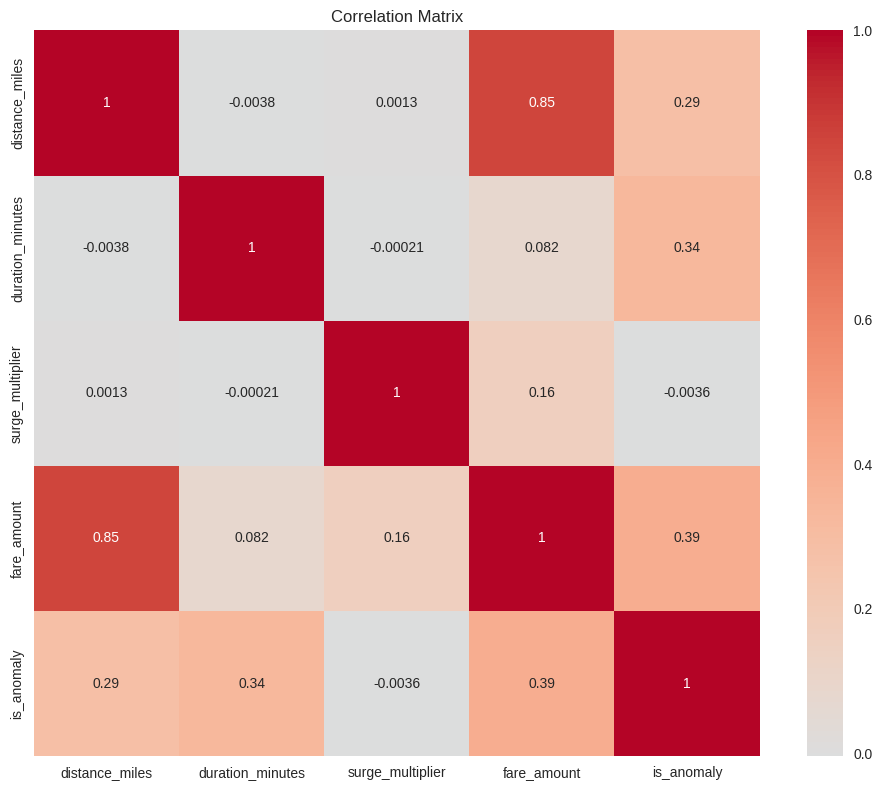

In [7]:
# Correlation analysis
numeric_columns = ['distance_miles', 'duration_minutes', 'surge_multiplier', 'fare_amount', 'is_anomaly']
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [8]:
# Anomaly Detection using Isolation Forest
print("Training Isolation Forest for Anomaly Detection...")

# Prepare features for anomaly detection
features = ['distance_miles', 'duration_minutes', 'fare_amount', 'surge_multiplier']
X = df[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # Expected anomaly rate
    random_state=42
)

# Fit and predict
df['predicted_anomaly'] = iso_forest.fit_predict(X_scaled)
df['predicted_anomaly'] = df['predicted_anomaly'].apply(lambda x: 1 if x == -1 else 0)
df['anomaly_score'] = iso_forest.decision_function(X_scaled)

print("Anomaly Detection Results:")
print("="*50)
print(f"True anomalies: {df['is_anomaly'].sum()}")
print(f"Predicted anomalies: {df['predicted_anomaly'].sum()}")

Training Isolation Forest for Anomaly Detection...
Anomaly Detection Results:
True anomalies: 2505
Predicted anomalies: 2500


Model Evaluation:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     47495
           1       0.49      0.49      0.49      2505

    accuracy                           0.95     50000
   macro avg       0.73      0.73      0.73     50000
weighted avg       0.95      0.95      0.95     50000



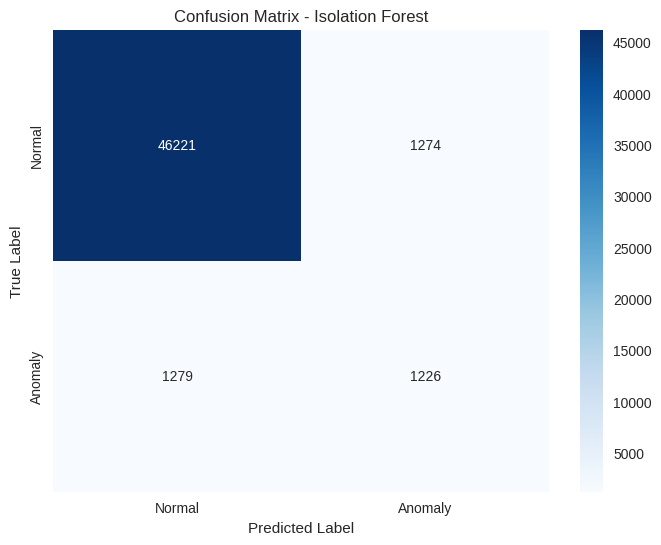

In [9]:
# Model Evaluation
print("Model Evaluation:")
print("="*50)
print(classification_report(df['is_anomaly'], df['predicted_anomaly']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(df['is_anomaly'], df['predicted_anomaly'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix - Isolation Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [10]:
# Analyze detected anomalies
true_positives = df[(df['is_anomaly'] == 1) & (df['predicted_anomaly'] == 1)]
false_positives = df[(df['is_anomaly'] == 0) & (df['predicted_anomaly'] == 1)]
false_negatives = df[(df['is_anomaly'] == 1) & (df['predicted_anomaly'] == 0)]

print(f"True Positives: {len(true_positives)}")
print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

# Feature importance analysis (based on anomaly scores)
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': np.abs(iso_forest.estimators_[0].feature_importances_)
}).sort_values('importance', ascending=False)

print("\nFeature Importance for Anomaly Detection:")
print(feature_importance)

True Positives: 1226
False Positives: 1274
False Negatives: 1279

Feature Importance for Anomaly Detection:
            feature  importance
1  duration_minutes    0.430881
0    distance_miles    0.242573
2       fare_amount    0.230404
3  surge_multiplier    0.096143


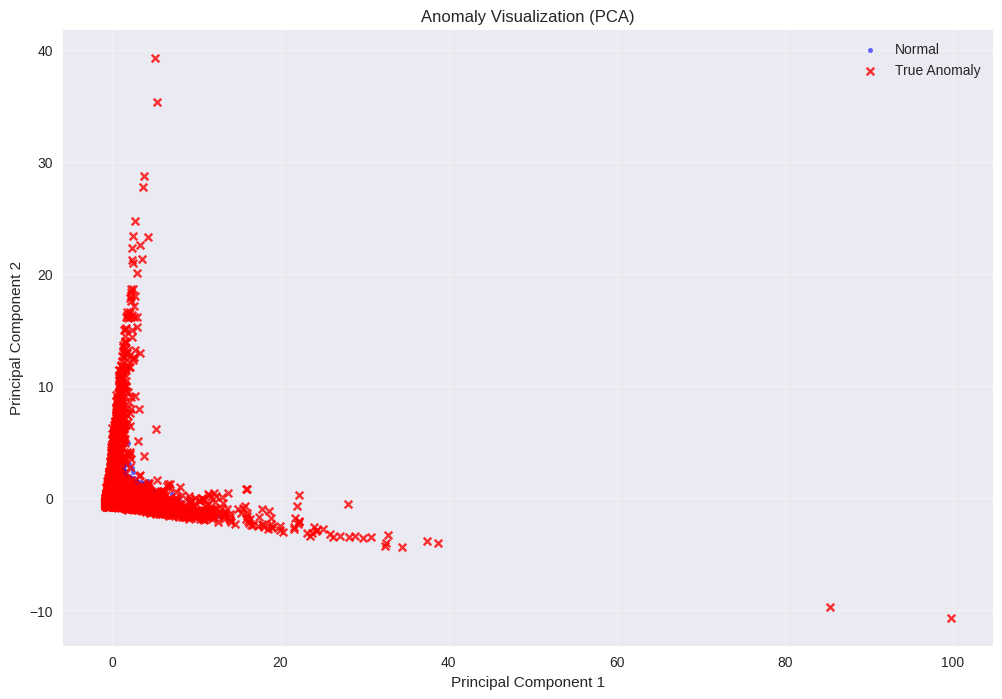

In [11]:
# Visualize anomalies in 2D space using PCA
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))

# Plot normal points
normal_mask = df['is_anomaly'] == 0
plt.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1],
           c='blue', alpha=0.6, s=10, label='Normal')

# Plot true anomalies
anomaly_mask = df['is_anomaly'] == 1
plt.scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1],
           c='red', alpha=0.8, s=30, label='True Anomaly', marker='x')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Anomaly Visualization (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Summary statistics for anomalies vs normal
print("Summary Statistics - Normal vs Anomalous Trips:")
print("="*60)

summary_stats = df.groupby('is_anomaly')[['fare_amount', 'distance_miles', 'duration_minutes', 'surge_multiplier']].describe()
display(summary_stats)

# Most extreme anomalies
print("\nTop 10 Most Extreme Anomalies (by fare):")
extreme_anomalies = df[df['is_anomaly'] == 1].nlargest(10, 'fare_amount')[['trip_id', 'fare_amount', 'distance_miles', 'duration_minutes', 'anomaly_type']]
display(extreme_anomalies)

Summary Statistics - Normal vs Anomalous Trips:


fare_amount                                                        \
                 count        mean         std    min    25%     50%     75%   
is_anomaly                                                                     
0              47495.0   68.690303   53.170900  11.34  36.77   53.61   81.83   
1               2505.0  278.964954  418.970596   5.00  33.45  151.41  352.45   

                    distance_miles             ... duration_minutes          \
                max          count       mean  ...              75%     max   
is_anomaly                                     ...                            
0           1052.47        47495.0  16.835381  ...             30.3   295.1   
1           7520.01         2505.0  66.596758  ...             66.1  1447.6   

           surge_multiplier                                                
                      count      mean       std  min  25%  50%   75%  max  
is_anomaly                                                                 
0                   47495.0  1.198819  0.312666  1.0  1.0  1.0  1.40  2.0  
1                    2505.0  1.193653  0.312297  1.0  1.0  1.0  1.39  2.0  

[2 rows x 32 columns]


Top 10 Most Extreme Anomalies (by fare):


,trip_id,fare_amount,distance_miles,duration_minutes,anomaly_type
31566,trip_031566,7520.01,3003.15,13.8,distance_outlier
18571,trip_018571,6472.95,2583.49,20.7,distance_outlier
25963,trip_025963,4219.36,176.53,23.2,overcharge
38051,trip_038051,3485.13,85.28,19.9,overcharge
5791,trip_005791,2954.73,1177.19,12.6,distance_outlier
4962,trip_004962,2878.78,1143.23,42.3,distance_outlier
22031,trip_022031,2660.82,1059.37,14.6,distance_outlier
34059,trip_034059,2578.03,46.66,36.3,overcharge
25165,trip_025165,2536.40,1006.12,43.6,distance_outlier
10112,trip_010112,2513.95,1000.22,18.0,distance_outlier
